# PREDICTOR FOR OBI SAMPLES WITH HUMAN MODEL


Training starting from best saved model

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
from keras import backend as K


In [2]:
#CHECK GOOGLE COLAB
GOOGLE_COLAB=False
if 'google.colab' in str(get_ipython()):
  GOOGLE_COLAB=True  
  print('Running on CoLab')
else:
  print('Not running on CoLab')

#CHECK GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Num GPUs Available: {}'.format(len(tf.config.list_physical_devices('GPU'))))
  print('Found GPU at: {}'.format(device_name))
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
     print('Not connected to a GPU')
  else:
     print(gpu_info)


#INIT 
data_dir=''
fname=''
models_dir=''

Not running on CoLab
Num GPUs Available: 1
Found GPU at: /device:GPU:0
Tue Mar 28 21:31:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0    N/A /  N/A |    164MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                 

In [3]:
########################################
# PARAMS
########################################
padding=True
model_name = 'LSTMBidiAttention9'
cross_test_name = 'Predict_Hs_to_Mm'
fname = 'mm10_DL_Pad_W50_BALANCED_1_1_CODED2CH.csv'

numchannels=2

if numchannels==3:
   categories_size=60
else:
   categories_size=20

if padding==True:
    categories_size=categories_size+1

if GOOGLE_COLAB==False:
    data_dir = '../../data/datasets/ALL_MM/W50'
    models_dir = './SAVED_MODELS'

else:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks')    
    data_dir  = '/content/drive/MyDrive/DATASETS/ALL_MM/W50'
    models_dir= '/content/drive/MyDrive/MODELS'
#########################################

In [4]:
saved_model =  model_name+'.h5'
savedmodelfile = os.path.join(models_dir, saved_model)
print("MODEL FILE: {}".format(savedmodelfile))

MODEL FILE: ./SAVED_MODELS\LSTMBidiAttention9.h5


In [5]:
datafile = os.path.join(data_dir, fname)
print("DATASET: {}".format(datafile))
dataraw = pd.read_csv(datafile,sep=";")
print("shape dataraw={}".format(dataraw.shape))

DATASET: ../../data/datasets/ALL_MM/W50\mm10_DL_Pad_W50_BALANCED_1_1_CODED2CH.csv
shape dataraw=(59294, 104)


In [6]:
#dataset=dataraw[dataraw.columns[3:len(dataraw.columns)]]
X=dataraw.iloc[:,3:]
Y=dataraw['EDITING']

random_seed=2022
fraction_to_test=0.9
print("fraction_to_test={}".format(fraction_to_test))
x_out, x_test, y_out, y_test = train_test_split(X, Y, test_size=fraction_to_test, random_state=random_seed)

print("x_test.shape={}".format(x_test.shape))
print("y_test.shape={}".format(y_test.shape))
print("TEST LABELS:")
print(y_test.value_counts())

#free memory
del dataraw
del X
del Y

fraction_to_test=0.9
x_test.shape=(53365, 101)
y_test.shape=(53365,)
TEST LABELS:
0    26718
1    26647
Name: EDITING, dtype: int64


Recover saved model

In [7]:
#Load the trained model from disk
import os.path

if os.path.exists(savedmodelfile):
    model = tf.keras.models.load_model(savedmodelfile)
    # Show the model architecture
    model.summary()
else:
    print("ERROR model {} nor found ".format(savedmodelfile))           



ValueError: bad marshal data (unknown type code)

In [8]:
#PREDICTIONS
#DataGenerator converts on the fly from raw data to one-hot
from RNAEd import DataGenerator

num_nucleosides = x_test.shape[1]
num_tokens = categories_size

pred_generator = DataGenerator(x_test, y_test,  batch_size=1,seq_size=num_nucleosides, categories_size=categories_size, shuffle=False )
model_prediction = model.predict(pred_generator,verbose=1)
model_prediction_binary = (model_prediction > 0.5).astype("int32")

ModuleNotFoundError: No module named 'RNAEd'

In [10]:
print(x_test.shape)
print(y_test.shape)
print(model_prediction.shape)
print(model_prediction_binary.shape)

(53365, 101)
(53365,)
(53365, 1)
(53365, 1)


In [11]:
#METRICS QUALITY CLASSIFICATION

print("MODEL "+model_name+"\n---------------------------------")
kappa = cohen_kappa_score(y_test, model_prediction_binary)
print ('Kappa:',round(kappa,3))
print(classification_report(y_test, model_prediction_binary))

MODEL LSTMBidiAttention9
---------------------------------
Kappa: 0.251
              precision    recall  f1-score   support

           0       0.57      0.97      0.72     26718
           1       0.91      0.28      0.43     26647

    accuracy                           0.63     53365
   macro avg       0.74      0.63      0.57     53365
weighted avg       0.74      0.63      0.57     53365



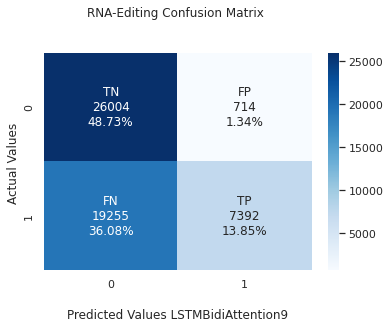

In [12]:
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
# PLOT CONFUSION MATRIX
# Tutorial: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
plt.figure()

cm = confusion_matrix(y_test,model_prediction_binary)

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

ax.set_title('RNA-Editing Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values '+ model_name)
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['False','True'])
#ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

auc = roc_auc_score(y_test, model_prediction)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, model_prediction)
plot_roc_curve(fpr, tpr)

In [ ]:
results_data = dataraw
if 'RESULT_TYPE' not in results_data.columns:
    #insert column at position 3
    results_data.insert(3,"RESULT_TYPE", None)
    results_data.insert(4,"PROB_PRED",model_prediction)
else:
    print("RESULT_TYPE already exists in the dataframe")

results_data.head()

In [ ]:
column_index=results_data.columns.get_loc('RESULT_TYPE')
i=0
for result in model_prediction_binary:
    #print("Comparing result={} with data_y_test={}".format(result[0],data_y_test.iloc[i]))
    if   result[0]==0 and y_test.iloc[i]==0:
       typeRes ="TN"
    elif result[0]==0 and y_test.iloc[i]==1:
       typeRes="FN"
    elif result[0]==1 and y_test.iloc[i]==0:
       typeRes="FP"
    elif result[0]==1 and y_test.iloc[i]==1:
       typeRes="TP"
    results_data.iloc[i, column_index]=typeRes
    i+=1
    
results_data.head()

In [ ]:
#Save the results into a file
if GOOGLE_COLAB==False:
    report_dir="./report"
else:
    report_dir="/content/drive/MyDrive/REPORT"

results_csv_file  =cross_test_name + "_Results.csv"
results_excel_file=cross_test_name + "_Results.xlsx"
results_data.to_csv(os.path.join(report_dir,results_csv_file))
results_data.to_excel(os.path.join(report_dir,results_excel_file))

In [ ]:
subset_TP=results_data.loc[results_data['RESULT_TYPE'] == 'TP']
prototype_of_TP_id=subset_TP['PROB_PRED'].idxmax()
print("rowid best TP = {}".format(prototype_of_TP_id))
print(results_data.loc[prototype_of_TP_id,])

In [ ]:
subset_TN=results_data.loc[results_data['RESULT_TYPE'] == 'TN']
prototype_of_TN_id=subset_TN['PROB_PRED'].idxmin()
print("rowid best TN = {}".format(prototype_of_TN_id))
print(results_data.loc[prototype_of_TN_id,])